# Complexity Lexicon Construction

## (1.0) Load Datasets

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

## (1.1) Load Embedding Models

### (1.1.1) Load GloVe embeddings

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_defs = [#Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
              #Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
              Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
              Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
              #Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

glove_models = []
for model in glove_defs:
    glove_file = datapath(MAIN_PATH + model.name)
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

### (1.1.2) Load word2vec embeddings

In [159]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'
model_word2vec = Model('word2vec', 'GoogleNews-vectors-negative300.bin' , 300, 'GoogleNews', \
            KeyedVectors.load_word2vec_format(datapath(MAIN_PATH + 'GoogleNews-vectors-negative300.bin'), binary=True))

### (1.1.3) Load FastText embeddings

In [160]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'
model_fastText = Model('FastText', 'wiki.en.vec', 300, 'Wikipedia', \
                 KeyedVectors.load_word2vec_format(MAIN_PATH + 'wiki.en.vec'))

In [161]:
models = []
models.extend(glove_models)
models.append(model_word2vec)
models.append(model_fastText)

## (2) Boostrapped Lexicon Construction

### (2.1) Baseline

In [308]:
from collections import Counter

'''
Extract all words that are exactly identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are neglected for the vocabulary
'''
def build_clean_vocabulary(train):
    targets_complex = set([mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()])
    targets_non_complex = set([mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()])
    targets_complex_cleaned = list(targets_complex.difference(targets_non_complex))
    targets_non_complex_cleaned = list(targets_non_complex.difference(targets_complex))
    vocabulary = {}
    for target in targets_complex_cleaned:
        vocabulary[target] = 1
    for target in targets_non_complex_cleaned:
        vocabulary[target] = 0
    return vocabulary

'''
Extract all words that are identified as either complex
or non-complex and use this as the vocabulary. Words that occur
as both complex and non-complex are weighted based on the number
of occurrences. If the word has been tagged more times as non-complex
we save it as non-complex otherwise it is complex
'''
def build_weighted_vocabulary(train):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 1,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_1(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] < confidence,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary

def build_confidence_vocabulary_2(train, confidence):
    targets_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['prob'] >= confidence,]['target'].tolist()]
    targets_non_complex = [mwe.strip().lower() for mwe in 
                train.loc[train['binary'] == 0,]['target'].tolist()]
    counts_complex = Counter(targets_complex)
    counts_non_complex = Counter(targets_non_complex)
    vocabulary = {}
    for word, count in counts_complex.items():
        count_nc = counts_non_complex.get(word, None)
        if count_nc and count_nc > count:
            vocabulary[word] = 0
        else:
            vocabulary[word] = 1
    for word, count in counts_non_complex.items():
        if word not in vocabulary:
            vocabulary[word] = 0
    return vocabulary
    

def evaluate_label_target_predictions(test, vocabulary):
    dict_test = list(zip(test.target, test.binary))
    data = [(binary, (vocabulary[target.strip().lower()] if target.strip().lower() in vocabulary else 1)) 
            for target, binary in dict_test]
    y_true = [vals[0] for vals in data]
    prediction = [vals[1] for vals in data]
    return f1_score(y_true, prediction)

evaluation_clean = [(evaluate_label_target_predictions(ds.test, 
                    build_clean_vocabulary(ds.train)), ds.name) for ds in datasets]
evaluation_weighted = [(evaluate_label_target_predictions(ds.test, 
                    build_weighted_vocabulary(ds.train)), ds.name) for ds in datasets]
evaluation_conf = [(evaluate_label_target_predictions(ds.test, 
                    build_confidence_vocabulary_2(ds.train, 0.5)), ds.name) for ds in datasets]

print('----------Evaluation clean-----------')
print(evaluation_clean)
print('----------Evaluation weighted-----------')
print(evaluation_weighted)
print('----------Evaluation confidence-----------')
print(evaluation_conf)

----------Evaluation clean-----------
[(0.7368421052631579, 'Wikipedia'), (0.7172264355362947, 'WikiNews'), (0.7416481069042317, 'News')]
----------Evaluation weighted-----------
[(0.746987951807229, 'Wikipedia'), (0.7390300230946882, 'WikiNews'), (0.8083441981747066, 'News')]
----------Evaluation confidence-----------
[(0.7398273736128236, 'Wikipedia'), (0.7184466019417476, 'WikiNews'), (0.7473002159827213, 'News')]


### (2.2) Boostrapping Lexicon

In [7]:
def ngram_embedding_similarity(model, word_l, word_r, missing_strat, ngram_repr):
    vecs_l = [model[word.strip().lower()] if word.strip().lower() in model.vocab 
                  else missing_strat(word, model.vector_size) 
                  for word in word_l.split()]   
    vecs_r = [model[word.strip().lower()] if word.strip().lower() in model.vocab \
                else missing_strat(word, model.vector_size)
                for word in word_r.split()]
    vec_l = ngram_repr(np.array(vecs_l))
    vec_r = ngram_repr(np.array(vecs_r))
    return np.dot(vec_l,vec_r) / (np.linalg.norm(vec_l) \
            * np.linalg.norm(vec_r))

In [173]:
def bootstrap_lexicon(model, vocab, seeds_l, seeds_r, embedding_sim, \
                      missing_strat, ref_term, ngram_repr, agg_embed=True, epochs=10, \
                      bound_l=-1, bound_r=1, thresh_l=-0.5,thresh_r=0.5):
    if not all(seed in vocab for seed in seeds_l):
        raise ValueError('Not all left seeds contained in vocabulary')
    if not all(seed in vocab for seed in seeds_r):
        raise ValueError('Not all right seeds contained in vocabulary')
    num_missing = np.sum([np.sum([1 for word in mwe.split()
                        if word.strip().lower() not in model.vocab]) for mwe in vocab])
    print('Missing vocab in model : {} / {}%'.format(num_missing, \
          (num_missing/len(vocab)*100)))
    if agg_embed:
        internal_vocab = vocab
    else:
        internal_vocab = [word for mwe in vocab for word in mwe.split()]
    # 1. Initialize the left and right seeds
    se_l = {seed : bound_l for seed in seeds_l}
    se_r = {seed : bound_r for seed in seeds_r}
    lexicon = se_l.copy()
    lexicon.update(se_r)
    for curr_epoch in range(1,epochs+1):
        # 2. Compute left and right weights
        print(se_l)
        sum_l = np.abs(np.sum([score for word, score in se_l.items()]))
        sum_r = np.abs(np.sum([score for word, score in se_r.items()]))
        weight_l = sum_r / (sum_r + sum_l)
        weight_r = sum_l / (sum_r + sum_l)
        print(sum_l)
        print(sum_r)
        print('Epoch {} : Se_l_size = {}, Se_r_size = {}, weight_l = {}, weight_r = {},'.format(\
                      curr_epoch, len(se_l), len(se_r), weight_l, weight_r))
        for index, curr_word in enumerate(internal_vocab):
            if((index % 500) == 0):
                print('{}|{}:{}%   '.format(index, len(internal_vocab), 
                                    (index/len(internal_vocab))), end='')
            if curr_word in se_l or curr_word in se_r:
                continue
            # Compute the weighted left and right scores and sum them
            score_l = [(weight_l * score * \
                        embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)) \
                        for seed, score in se_l.items()]
            score_r = [(weight_r * score * \
                        embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)) \
                        for seed, score in se_r.items()]
            print('Word : {}'.format(curr_word))
            print(score_r)
            print(score_l)
            score = np.sum(score_l) + np.sum(score_r)
            print('final score : {}'.format(score))
            lexicon[curr_word] = score
            print('{} : {}'.format(curr_word, score))
            # Add word to the seed set if the score is low or high enough
            if score <= thresh_l: se_l[curr_word] = score
            if score >= thresh_r: se_r[curr_word] = score
        #print(lexicon)
    # 3. Compute final scores and normalize them
    sim_ref = lexicon.get(ref_term)
    #print('SIM_REF:{}'.format(sim_ref))
    if not sim_ref:
        return ValueError('Reference term {} not found in lexicon'.format(ref_term))
    coll_l = {seed : (score - sim_ref) for seed, score in lexicon.items() \
                if (score - sim_ref) < 0}
    coll_r = {seed : (score - sim_ref) for seed, score in lexicon.items() \
                if (score - sim_ref) > 0}
    max_l = np.max(np.abs([score for _, score in coll_l.items()]))
    max_r = np.max(np.abs([score for _, score in coll_r.items()]))
    #print(coll_l)
    #print(max_l)
    lexicon[ref_term] = lexicon[ref_term] - sim_ref
    for word, score in coll_l.items():
        lexicon[word] = score / max_l
    for word, score in coll_r.items():
        lexicon[word] = score / max_r
    # 4. Aggregate MWE complexity scores
    if not agg_embed:
        for mwe in vocab:
            lexicon[mwe] = np.mean([lexicon[word] for word in mwe.split()])
    return lexicon



def bootstrap_lexicon_average(models, vocab, seeds_l, seeds_r, embedding_sim, \
                      missing_strat, ref_term, ngram_repr, agg_embed=True, epochs=10, \
                      bound_l=-1, bound_r=1, thresh_l=-0.5,thresh_r=0.5):
    if not all(seed in vocab for seed in seeds_l):
        raise ValueError('Not all left seeds contained in vocabulary')
    if not all(seed in vocab for seed in seeds_r):
        raise ValueError('Not all right seeds contained in vocabulary')
    num_missing = np.sum([np.sum([1 for word in mwe.split()
                        if word.strip().lower() not in model[0].vocab]) for mwe in vocab])
    print('Missing vocab in models : {} / {}%'.format(num_missing, \
          (num_missing/len(vocab)*100)))
    if agg_embed:
        internal_vocab = vocab
    else:
        internal_vocab = [word for mwe in vocab for word in mwe.split()]
    # 1. Initialize the left and right seeds
    se_l = {seed : bound_l for seed in seeds_l}
    se_r = {seed : bound_r for seed in seeds_r}
    internal_lexicon = se_l.copy()
    internal_lexicon.update(se_r)
    for curr_epoch in range(1,epochs+1):
        print('Epoch {} : Se_l_size = {}, Se_r_size = {}'.format(\
                      curr_epoch, len(se_l), len(se_r)))
        for index, curr_word in enumerate(internal_vocab):
            if((index % 500) == 0):
                print('{}|{}:{}%   '.format(index, len(internal_vocab), 
                                    (index/len(internal_vocab))), end='')
            if curr_word in se_l or curr_word in se_r:
                continue
            # Compute the weighted left and right scores and sum them
            score_l = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr) 
                                for model in models])) \
                        for seed, score in se_l.items()]
            score_r = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)
                                for model in models])) \
                        for seed, score in se_r.items()]
            #print('Word : {}'.format(curr_word))
            #print(score_r)
            #print(score_l)
            score = np.mean(score_l) + np.mean(score_r)
            #print('final score : {}'.format(score))
            internal_lexicon[curr_word] = score
            #print('{} : {}'.format(curr_word, score))
            # Add word to the seed set if the score is low or high enough
            if score <= thresh_l: se_l[curr_word] = score
            if score >= thresh_r: se_r[curr_word] = score
        #print(lexicon)
    # 3. Compute final scores and normalize them
    sim_ref = internal_lexicon.get(ref_term)
    print('SIM_REF:{}'.format(sim_ref))
    if not sim_ref:
        return ValueError('Reference term {} not found in lexicon'.format(ref_term))
    coll_l = {seed : (score - sim_ref) for seed, score in internal_lexicon.items() \
                if (score - sim_ref) < 0}
    coll_r = {seed : (score - sim_ref) for seed, score in internal_lexicon.items() \
                if (score - sim_ref) > 0}
    max_l = np.max(np.abs([score for _, score in coll_l.items()]))
    max_r = np.max(np.abs([score for _, score in coll_r.items()]))
    #print(coll_l)
    #print(max_l)
    internal_lexicon[ref_term] = internal_lexicon[ref_term] - sim_ref
    for word, score in coll_l.items():
        internal_lexicon[word] = score / max_l
    for word, score in coll_r.items():
        internal_lexicon[word] = score / max_r
    # 4. Aggregate MWE complexity scores
    lexicon = {}
    for word in vocab:
        tokens = word.split()
        if len(tokens) > 1 and not agg_embed:
            lexicon[word] = np.mean([internal_lexicon[token] 
                                     for token in tokens])
        else:
            lexicon[word] = internal_lexicon[word]
    return lexicon

def bootstrap_lexicon_average_no_ref(models, vocab, seeds_l, seeds_r, embedding_sim, \
                      missing_strat, ngram_repr, agg_embed=True, epochs=10, \
                      bound_l=-1, bound_r=1, thresh_l=-0.5,thresh_r=0.5):
    if not all(seed in vocab for seed in seeds_l):
        raise ValueError('Not all left seeds contained in vocabulary')
    if not all(seed in vocab for seed in seeds_r):
        raise ValueError('Not all right seeds contained in vocabulary')
    num_missing = np.sum([np.sum([1 for word in mwe.split()
                        if word.strip().lower() not in model[0].vocab]) for mwe in vocab])
    print('Missing vocab in models : {} / {}%'.format(num_missing, \
          (num_missing/len(vocab)*100)))
    if agg_embed:
        internal_vocab = vocab
    else:
        internal_vocab = [word for mwe in vocab for word in mwe.split()]
    # 1. Initialize the left and right seeds
    se_l = {seed : bound_l for seed in seeds_l}
    se_r = {seed : bound_r for seed in seeds_r}
    internal_lexicon = se_l.copy()
    internal_lexicon.update(se_r)
    for curr_epoch in range(1,epochs+1):
        print('Epoch {} : Se_l_size = {}, Se_r_size = {}'.format(\
                      curr_epoch, len(se_l), len(se_r)))
        for index, curr_word in enumerate(internal_vocab):
            if((index % 500) == 0):
                print('{}|{}:{}%   '.format(index, len(internal_vocab), 
                                    (index/len(internal_vocab))), end='')
            if curr_word in se_l or curr_word in se_r:
                continue
            # Compute the weighted left and right scores and sum them
            score_l = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr) 
                                for model in models])) \
                        for seed, score in se_l.items()]
            score_r = [(score * \
                        np.mean([embedding_sim(model, curr_word, seed, missing_strat, ngram_repr)
                                for model in models])) \
                        for seed, score in se_r.items()]
            #print('Word : {}'.format(curr_word))
            #print(score_r)
            #print(score_l)
            score = np.mean(score_l) + np.mean(score_r)
            #print('final score : {}'.format(score))
            internal_lexicon[curr_word] = score
            #print('{} : {}'.format(curr_word, score))
            # Add word to the seed set if the score is low or high enough
            if score <= thresh_l: se_l[curr_word] = score
            if score >= thresh_r: se_r[curr_word] = score
        #print(lexicon)
    # 4. Aggregate MWE complexity scores
    lexicon = {}
    for word in vocab:
        tokens = word.split()
        if len(tokens) > 1 and not agg_embed:
            lexicon[word] = np.mean([internal_lexicon[token] 
                                     for token in tokens])
        else:
            lexicon[word] = internal_lexicon[word]
    return lexicon

## (3) Toy-Example Lexicon

### (3.1) Single Model with reference term and score aggregation

In [174]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad', 'worse', 'unfortunately', 'really']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

model = [models[0].model]
ref_term = 'and'
lexicon = bootstrap_lexicon_average(model, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, ref_term, \
                  ngram_repr_bow_mean, agg_embed=False, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad', 'worse', 'unfortunately', 'really']
---------Vocabulary----------------
['aboriginal', 'bad', 'worse', 'unfortunately', 'really', 'good', 'inuit', 'and', 'to this end']
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 4, Se_r_size = 1
0|11:0.0%   Epoch 2 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   Epoch 3 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   SIM_REF:-0.33638048225707995
{'aboriginal': 1.0, 'bad': -1.0, 'worse': -1.0, 'unfortunately': -1.0, 'really': -1.0, 'good': -0.43517536551322916, 'inuit': 0.8350315056510479, 'and': 0.0, 'to this end': -0.266093955672061}


### (3.2) Single Model and score aggregation

In [175]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad', 'worse', 'unfortunately', 'really']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

model = [models[0].model]
lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, \
                  ngram_repr_bow_mean, agg_embed=False, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad', 'worse', 'unfortunately', 'really']
---------Vocabulary----------------
['aboriginal', 'bad', 'worse', 'unfortunately', 'really', 'good', 'inuit', 'and', 'to this end']
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 4, Se_r_size = 1
0|11:0.0%   Epoch 2 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   Epoch 3 : Se_l_size = 7, Se_r_size = 2
0|11:0.0%   {'aboriginal': 1, 'bad': -1, 'worse': -1, 'unfortunately': -1, 'really': -1, 'good': -0.625171348452568, 'inuit': 0.7795393239647231, 'and': -0.33638048225707995, 'to this end': -0.512965624794479}


### (3.3) Multiple Models with reference term and score aggregation

In [176]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end', 'extraordinary'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

models_selected = [model.model for model in models]
ref_term = 'and'
lexicon = bootstrap_lexicon_average(models_selected, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, ref_term, \
                  ngram_repr_bow_mean, agg_embed=False, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad']
---------Vocabulary----------------
['aboriginal', 'bad', 'good', 'inuit', 'and', 'to this end', 'extraordinary']
[<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000741AD63A90>, <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x00000074283E2EF0>, <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x00000074158159E8>, <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000007415817AC8>]
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 1, Se_r_size = 1
0|9:0.0%   Epoch 2 : Se_l_size = 2, Se_r_size = 2
0|9:0.0%   Epoch 3 : Se_l_size = 2, Se_r_size = 2
0|9:0.0%   SIM_REF:-0.1700541415844552
{'aboriginal': 1.0, 'bad': -1.0, 'good': -0.5230610309483759, 'inuit': 0.5964667506036255, 'and': 0.0, 'to this end': -0.1312578920535429, 'extraordinary': 0.020110890897360213}


### (3.4) Single Model with reference term and embedding aggregation

In [177]:
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
import gensim

seeds_complex = ['aboriginal']
seeds_non_complex = ['bad', 'worse', 'unfortunately', 'really']

# Build the vocabulary
vocabulary = []
vocabulary.extend(seeds_complex)
vocabulary.extend(seeds_non_complex)
vocabulary.extend(['good', 'inuit', 'and', 'to this end'])

print('---------Complex Seeds----------------')
print(seeds_complex)
print('---------Non-Complex Seeds----------------')
print(seeds_non_complex)
print('---------Vocabulary----------------')
print(vocabulary)

model = [models[0].model]
ref_term = 'and'
lexicon = bootstrap_lexicon_average(model, vocabulary, seeds_non_complex, seeds_complex, \
                  ngram_embedding_similarity, missing_strat_random, ref_term, \
                  ngram_repr_bow_mean, agg_embed=True, epochs=3, thresh_l=-0.5, thresh_r=0.5)
print(lexicon)

---------Complex Seeds----------------
['aboriginal']
---------Non-Complex Seeds----------------
['bad', 'worse', 'unfortunately', 'really']
---------Vocabulary----------------
['aboriginal', 'bad', 'worse', 'unfortunately', 'really', 'good', 'inuit', 'and', 'to this end']
Missing vocab in models : 0.0 / 0.0%
Epoch 1 : Se_l_size = 4, Se_r_size = 1
0|9:0.0%   Epoch 2 : Se_l_size = 6, Se_r_size = 2
0|9:0.0%   Epoch 3 : Se_l_size = 6, Se_r_size = 2
0|9:0.0%   SIM_REF:-0.36147909368740827
{'aboriginal': 1.0, 'bad': -1.0, 'worse': -1.0, 'unfortunately': -1.0, 'really': -1.0, 'good': -0.41297356462134016, 'inuit': 0.8380726688661927, 'and': 0.0, 'to this end': -0.31752104683715165}


## (4) Complexity Lexicon

In [222]:
def construct_pairs(lexicon, df_test):
    dict_test = list(zip(df_test.target, df_test.binary))
    return [(target, binary, lexicon[target.strip().lower()]) 
            for target, binary in dict_test]

### (4.1) MWE with Embedding Aggregation

In [319]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=True
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = [datasets[0]]

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    vocabulary.append(ref_term)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 694
Missing vocab in models : 201.0 / 4.705056179775281%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|4272:0.0%   500|4272:0.11704119850187265%   1000|4272:0.2340823970037453%   1500|4272:0.351123595505618%   2000|4272:0.4681647940074906%   2500|4272:0.5852059925093633%   3000|4272:0.702247191011236%   3500|4272:0.8192883895131086%   4000|4272:0.9363295880149812%   

C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


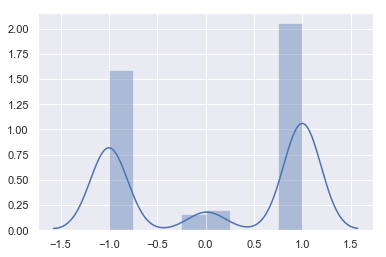

In [320]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [321]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [322]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
print(len(y_true))
prediction = [pair[2] for pair in pairs]
print(len(prediction))
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-1 else 0, prediction)))

694
694


0.746987951807229

### (4.2) MWE with Embedding Aggregation and Reference Term

In [314]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=True
ref_term = 'and'
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = [datasets[0]]

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    vocabulary.append(ref_term)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, ref_term=ref_term, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 694
Missing vocab in models : 201.0 / 4.705056179775281%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|4272:0.0%   500|4272:0.11704119850187265%   1000|4272:0.2340823970037453%   1500|4272:0.351123595505618%   2000|4272:0.4681647940074906%   2500|4272:0.5852059925093633%   3000|4272:0.702247191011236%   3500|4272:0.8192883895131086%   4000|4272:0.9363295880149812%   SIM_REF:-0.05605420319279125


C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


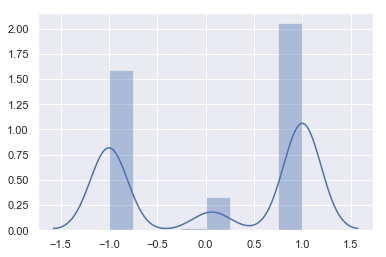

In [315]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [316]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [318]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
prediction = [pair[2] for pair in pairs]
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-1 else 0, prediction)))

0.746987951807229

### (4.3) MWE with Complexity Score Aggregation no reference term

In [179]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=False
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = [datasets[0]]

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    print('and' in vocabulary)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

---------Training Targets----------------
Targets complex : 7688
Target non-complex : 6316
Targets clean-complex : 6559
Target clean-non-complex : 5187
---------Testing Seeds----------------
Target test : 3328
False
-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 1901
Target non-complex : 1603
---------Testing Seeds----------------
Target test : 694
Missing vocab in models : 192.0 / 4.5736064792758455%
Epoch 1 : Se_l_size = 1504, Se_r_size = 1873
0|5306:0.0%   500|5306:0.09423294383716548%   1000|5306:0.18846588767433095%   1500|5306:0.28269883151149644%   2000|5306:0.3769317753486619%   2500|5306:0.47116471918582736%   3000|5306:0.5653976630229929%   3500|5306:0.6596306068601583%   4000|5306:0.7538635506973238%   4500|5306:0.8480964945344892%   5000|5306:0.9423294383716547%   

C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


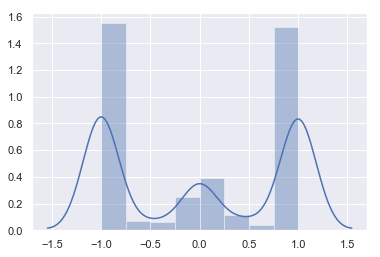

In [180]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [224]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [225]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
prediction = [pair[2] for pair in pairs]
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-0.7 else 0, prediction)))

694
694


0.7403055229142186

### (4.4) MWE with Complexity Score Aggregation no reference term (weighted seeds)

In [323]:
import pandas as pd
from ngram_representation import missing_strat_random
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_wiki_weighted_bow


# Get the basic seeds for complex and non_complex words
# Group targets into complex and non-complex and flatten MWE
targets_train = [(ds.name, build_weighted_vocabulary(ds.train)) for ds in datasets]
seeds_complex = [(name, [word for word, score in vocab.items() if score == 1]) for name, vocab in targets_train]
seeds_non_complex = [(name, [word for word, score in vocab.items() if score == 0]) for name, vocab in targets_train]

lexicons = []
# Parameters for lexicon construction
epochs=1
thresh_l=-0.5
thresh_r=0.5
agg_embed=False
embedding_sim = ngram_embedding_similarity
ngram_repr = ngram_repr_bow_max
missing_strat = missing_strat_random
model = [model.model for model in models]
data = [datasets[0]]

for ds in data:
    t_complex = [seeds for name, seeds in seeds_complex if name == ds.name][0]
    t_non_complex = [seeds for name, seeds in seeds_non_complex if name == ds.name][0]
    t_test = [d.test.target.tolist() for d in datasets 
              if d.name == ds.name][0]
    t_test = [mwe.strip().lower() for mwe in t_test]
    vocabulary = []
    vocabulary.extend(t_complex)
    vocabulary.extend(t_non_complex)
    vocabulary.extend(t_test)
    print('and' in vocabulary)
    print('-----------------------------------------')
    print('-----------------------------------------')
    print('Dataset :{}'.format(ds.name))
    print('---------Training Targets----------------')
    print('Targets complex : {}'.format(len(t_complex)))
    print('Target non-complex : {}'.format(len(t_non_complex)))
    print('---------Testing Seeds----------------')
    print('Target test : {}'.format(len(t_test)))
    lexicon = bootstrap_lexicon_average_no_ref(model, vocabulary, t_non_complex, t_complex, \
                  embedding_sim=embedding_sim, \
                  missing_strat=missing_strat, \
                  ngram_repr=ngram_repr, agg_embed=agg_embed, epochs=epochs, \
                  thresh_l=thresh_l, thresh_r=thresh_r)
    lexicons.append(Lexicon(ds.name, epochs, thresh_l, thresh_r, agg_embed, lexicon))

False
-----------------------------------------
-----------------------------------------
Dataset :Wikipedia
---------Training Targets----------------
Targets complex : 2019
Target non-complex : 1558
---------Testing Seeds----------------
Target test : 694
Missing vocab in models : 201.0 / 4.7061578084757665%
Epoch 1 : Se_l_size = 1558, Se_r_size = 2019
0|5380:0.0%   500|5380:0.09293680297397769%   1000|5380:0.18587360594795538%   1500|5380:0.2788104089219331%   2000|5380:0.37174721189591076%   2500|5380:0.4646840148698885%   3000|5380:0.5576208178438662%   3500|5380:0.6505576208178439%   4000|5380:0.7434944237918215%   4500|5380:0.8364312267657993%   5000|5380:0.929368029739777%   

C:\Users\Studio\Anaconda3\lib\site-packages\scipy\stats\stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


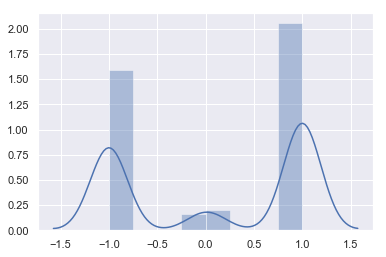

In [293]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
np.random.seed(0)
x = np.array([score for word, score in lexicon.items()])
ax = sns.distplot(x)
plt.show(ax)

In [294]:
pairs = [construct_pairs(lexicon.lexicon, ds.test)
            for lexicon in lexicons 
            for ds in datasets if lexicon.name == ds.name][0]

In [ ]:
import numpy
from sklearn.metrics import f1_score

y_true = [pair[1] for pair in pairs]
prediction = [pair[2] for pair in pairs]
numpy.corrcoef(y_true, prediction)[0, 1]
f1_score(y_true, list(map(lambda val: 1 if val>-0.7 else 0, prediction)))